# ICESat-2 Active Subglacial Lakes in Antarctica

Finding subglacial lakes that are draining or filling under the ice!
They can be detected with ICESat-2 data, as significant changes in height
(> 1 metre) over a relatively short duration (< 1 year), i.e. a high rate of
elevation change over time (dhdt).

In this notebook, we'll use some neat tools to help us examine the lakes:
- To find active subglacial lake boundaries,
use an *unsupervised clustering* technique
- To see ice surface elevation trends at a higher temporal resolution (< 3 months),
perform *crossover track error analysis* on intersecting ICESat-2 tracks

To speed up analysis on millions of points,
we will use state of the art GPU algorithms enabled by RAPIDS AI libraries,
or parallelize the processing across our HPC's many CPU cores using Dask.

Note: This notebook was adapted from
https://github.com/weiji14/deepicedrain/blob/v0.4.2/atlxi_dhdt.ipynb

In [25]:
import os

# import cudf
# import cuml
import geopandas as gpd
import numpy as np
import pandas as pd
# import pygmt
import scipy.spatial
import shapely.geometry
import tqdm

# import deepicedrain

## Load in ICESat-2 data (x, y, dhdt) and do initial trimming

In [5]:
# Read in raw x, y, dhdt_slope and referencegroundtrack data into the GPU
cudf_raw: pd.DataFrame = pd.read_parquet(
    path="https://github.com/weiji14/deepicedrain/releases/download/v0.4.2/df_dhdt_whillans_upstream.parquet",
    columns=["x", "y", "dhdt_slope", "referencegroundtrack"],
    # filters=[[('dhdt_slope', '<', -0.105)], [('dhdt_slope', '>', 0.105)]],
)
# Filter to points with dhdt that is less than -0.105 m/yr or more than +0.105 m/yr
# Based on ICESat-2 ATL06's accuracy and precision of 3.3 ± 7.2cm from Brunt et al 2020
# See https://doi.org/10.1029/2020GL090572
cudf_many = cudf_raw.loc[abs(cudf_raw.dhdt_slope) > 0.105]
print(f"Trimmed {len(cudf_raw)} -> {len(cudf_many)}")
if "cudf_raw" in globals():
    del cudf_raw

Trimmed 4400800 -> 2781831


In [6]:
# Clip outlier values to 3 sigma (standard deviations) from mean
_mean = cudf_many.dhdt_slope.mean()
_std = cudf_many.dhdt_slope.std()
cudf_many.dhdt_slope.clip(
    lower=np.float32(_mean - 3 * _std), upper=np.float32(_mean + 3 * _std)
)
X_many = cudf_many
X_many

,x,y,dhdt_slope,referencegroundtrack
0,-674266.855575,-400035.558755,0.361657,6
1,-674306.626769,-400078.173573,0.331515,6
2,-674346.406781,-400120.780361,0.359910,6
3,-674386.187284,-400163.386740,0.402465,6
4,-674425.611742,-400206.325432,0.300734,6
...,...,...,...,...
4476225,-400216.802567,-569525.939382,0.284563,1385
4476226,-400169.718641,-569491.642818,0.316296,1385
4476227,-400122.633688,-569457.347729,0.334779,1385
4476228,-400075.549059,-569423.052244,0.280224,1385


## Find Active Subglacial Lake clusters

Uses Density-based spatial clustering of applications with noise (DBSCAN).

In [10]:
def find_clusters(
    X: pd.DataFrame,
    eps: float = 3000,
    min_samples: int = 250,
    output_colname: str = "cluster_id",
    **kwargs,
) -> pd.Series:
    """
    Classify a point cloud into several groups, with each group being assigned
    a positive integer label like 1, 2, 3, etc. Unclassified noise points are
    labelled as NaN.
    Uses Density-based spatial clustering of applications with noise (DBSCAN).
    See also https://www.naftaliharris.com/blog/visualizing-dbscan-clustering
    ***       **         111       NN
    **    **   *         11    22   N
    *     ****     -->   1     2222
      **     **            33     22
    ******               333333
    Parameters
    ----------
    X : cudf.DataFrame or pandas.DataFrame
        A table of X, Y, Z points to run the clustering algorithm on.
    eps : float
        The maximum distance between 2 points such they reside in the same
        neighborhood. Default is 3000 (metres).
    min_samples : int
        The number of samples in a neighborhood such that this group can be
        considered as an important core point (including the point itself).
        Default is 250 (sample points).
    output_colname : str
        The name of the column for the output Series. Default is 'cluster_id'.
    kwargs : dict
        Extra parameters to pass into the `cuml.cluster.DBSCAN` or
        `sklearn.cluster.DBSCAN` function.
    Returns
    -------
    cluster_labels : cudf.Series or pd.Series
        Which cluster each datapoint belongs to. Noisy samples are labeled as
        NaN.
    """
    try:
        from cuml.cluster import DBSCAN
    except ImportError:
        from sklearn.cluster import DBSCAN

    # Run DBSCAN using {eps} m distance, and minimum of {min_samples} points
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, **kwargs)
    dbscan.fit(X=X)

    cluster_labels = dbscan.labels_ + 1  # noise points -1 becomes 0
    if isinstance(cluster_labels, np.ndarray):
        cluster_labels = pd.Series(data=cluster_labels, dtype=pd.Int32Dtype())
    cluster_labels = cluster_labels.mask(cond=cluster_labels == 0)  # turn 0 to NaN
    cluster_labels.index = X.index  # let labels have same index as input data
    cluster_labels.name = output_colname

    return cluster_labels

### Subglacial Lake Finder algorithm

For each Antarctic drainage basin:

1. Select all points with significant elevation change over time (dhdt)
  - Specifically, the (absolute) dhdt value should be
    2x the median (absolute) dhdt for that drainage basin
  - E.g. if median dhdt for basin is 0.35 m/yr,
    we choose points that have dhdt > 0.70 m/yr
2. Run unsupervised clustering to pick out active subglacial lakes
  - Split into draining (-dhdt) and filling (+dhdt) points first
  - Use DBSCAN algorithm to cluster points into groups,
    with an eps (distance) of 3 km and minimum sample size of 250 points
3. Check each potential point cluster to see if it meets active lake criteria
  1. Build a convex hull 'lake' polygon around clustered points
  2. Check that the 'lake' has significant elevation change relative to outside
    - For the area in the 5 km buffer region **outside** the 'lake' polygon:
       - Find median dhdt (outer_dhdt)
       - Find median absolute deviation of dhdt values (outer_mad)
    - For the area **inside** the 'lake' polygon:
       - Find median dhdt (inner_dhdt)
    - If the potential lake shows an elevation change that is more than
      3x the surrounding deviation of background elevation change,
      we infer that this is likely an active subglacial 'lake'

In [8]:
# Subglacial lake finder
activelakes: dict = {
    # "basin_name": [],  # Antarctic drainage basin name
    "refgtracks": [],  # Pipe-delimited list of ICESat-2 reference ground tracks
    "num_points": [],  # Number of clustered data points
    "maxabsdhdt": [],  # Maximum absolute dhdt value inside of lake boundary
    "inner_dhdt": [],  # Median elev change over time (dhdt) inside of lake bounds
    "mean_dhdt": [],  # Mean elev change over time (dhdt) inside of lake bounds
    "outer_dhdt": [],  # Median elevation change over time (dhdt) outside of lake
    "outer_std": [],  # Standard deviation of dhdt outside of lake
    "outer_mad": [],  # Median absolute deviation of dhdt outside of lake
    "geometry": [],  # Shapely Polygon geometry holding lake boundary coordinates
}
# basin_name: str = "Cook"  # Set a basin name here
# basins = drainage_basins[drainage_basins.NAME == basin_name].index  # one specific basin
# basins = drainage_basins[
#     drainage_basins.NAME.isin(("Cook", "Whillans"))
# ].index  # some specific basins
# basins: pd.core.indexes.numeric.Int64Index = drainage_basins.index  # run on all basins

eps: int = 3000  # ICESat-2 tracks are separated by ~3 km across track, with each laser pair ~90 m apart
min_samples: int = 300
for basin_index in tqdm.tqdm(iterable=[1]):
    # Initial data cleaning, filter to rows that are in the drainage basin
    # basin = drainage_basins.loc[basin_index]
    X_local = X_many #.loc[X_many.drainage_basin == basin.NAME]  # .reset_index(drop=True)

    # Get points with dhdt_slope higher than 3x the median dhdt_slope for the basin
    # E.g. if median dhdt_slope is 0.30 m/yr, then we cluster points over 0.90 m/yr
    abs_dhdt = X_local.dhdt_slope.abs()
    tolerance: float = 3 * abs_dhdt.median()
    X = X_local.loc[abs_dhdt > tolerance]

    if len(X) <= 1000:  # don't run on too few points
        continue

    # Run unsupervised clustering separately on draining and filling lakes
    # Draining lake points have negative labels (e.g. -1, -2, 3),
    # Filling lake points have positive labels (e.g. 1, 2, 3),
    # Noise points have NaN labels (i.e. NaN)
    cluster_vars = ["x", "y", "dhdt_slope"]
    draining_lake_labels = -find_clusters(
        X=X.loc[X.dhdt_slope < 0][cluster_vars],
        eps=eps,
        min_samples=min_samples,
        # verbose=cuml.common.logger.level_error,
    )
    filling_lake_labels = find_clusters(
        X=X.loc[X.dhdt_slope > 0][cluster_vars],
        eps=eps,
        min_samples=min_samples,
        # verbose=cuml.common.logger.level_error,
    )
    lake_labels = pd.concat(objs=[draining_lake_labels, filling_lake_labels])
    lake_labels: pd.Series = lake_labels.sort_index()
    assert lake_labels.name == "cluster_id"

    # Checking all potential subglacial lakes in a basin
    clusters: pd.Series = lake_labels.unique()
    for cluster_label in clusters:
        # Store attribute and geometry information of each active lake
        lake_points: pd.DataFrame = X.loc[lake_labels == cluster_label]

        # More data cleaning, dropping clusters with too few points
        try:
            assert len(lake_points) > 100
        except AssertionError:
            lake_labels = lake_labels.replace(to_replace=cluster_label, value=None)
            continue

        multipoint: shapely.geometry.MultiPoint = shapely.geometry.MultiPoint(
            points=lake_points[["x", "y"]].values  # .as_matrix()
        )
        convexhull: shapely.geometry.Polygon = multipoint.convex_hull

        # Filter out (most) false positive subglacial lakes
        # Check that elevation change over time in lake is anomalous to outside
        # The 5000 m distance from lake boundary setting is empirically based on
        # Smith et al. 2009's methodology at https://doi.org/10.3189/002214309789470879
        outer_ring_buffer = convexhull.buffer(distance=5000) - convexhull
        X_local["in_donut_ring"] = deepicedrain.point_in_polygon_gpu(
            points_df=X_local,
            poly_df=gpd.GeoDataFrame({"name": True, "geometry": [outer_ring_buffer]}),
        )
        outer_points = X_local.dropna(subset="in_donut_ring")
        outer_dhdt: float = outer_points.dhdt_slope.median()

        outer_std: float = outer_points.dhdt_slope.std()
        outer_mad: float = scipy.stats.median_abs_deviation(
            x=outer_points.dhdt_slope.to_pandas()
        )

        mean_dhdt: float = lake_points.dhdt_slope.mean()
        inner_dhdt: float = lake_points.dhdt_slope.median()
        X_local = X_local.drop(labels="in_donut_ring", axis="columns")

        # If lake interior's median dhdt value is within 3 median absolute deviations
        # of the lake exterior's dhdt value, we remove the lake label
        # I.e. skip if above background change not significant enough
        # Inspired by Kim et al. 2016's methodology at https://doi.org/10.5194/tc-10-2971-2016
        if abs(inner_dhdt - outer_dhdt) < 3 * outer_mad:
            lake_labels = lake_labels.replace(to_replace=cluster_label, value=None)
            continue

        maxabsdhdt: float = (
            lake_points.dhdt_slope.max()
            if cluster_label > 0  # positive label = filling
            else lake_points.dhdt_slope.min()  # negative label = draining
        )
        refgtracks: str = "|".join(
            map(str, lake_points.referencegroundtrack.unique().to_pandas())
        )

        # Save key variables to dictionary that will later go into geodataframe
        activelakes["basin_name"].append(basin.NAME)
        activelakes["refgtracks"].append(refgtracks)
        activelakes["num_points"].append(len(lake_points))
        activelakes["maxabsdhdt"].append(maxabsdhdt)
        activelakes["inner_dhdt"].append(inner_dhdt)
        activelakes["mean_dhdt"].append(mean_dhdt)
        activelakes["outer_dhdt"].append(outer_dhdt)
        activelakes["outer_std"].append(outer_std)
        activelakes["outer_mad"].append(outer_mad)
        activelakes["geometry"].append(convexhull)

    # Calculate total number of lakes found for one drainage basin
    clusters: pd.Series = lake_labels.unique()
    n_draining, n_filling = (clusters < 0).sum(), (clusters > 0).sum()
    if n_draining + n_filling > 0:
        print(f"{len(X)} rows at {basin.NAME} above ± {tolerance:.2f} m/yr")
        print(f"{n_draining} draining and {n_filling} filling lakes found")

if len(activelakes["geometry"]) >= 1:
    gdf = gpd.GeoDataFrame(activelakes, crs="EPSG:3031")
    basename = "antarctic_subglacial_lakes"  # f"temp_{basin_name.lower()}_lakes"  #
    gdf.to_file(filename=f"{basename}_3031.geojson", driver="GeoJSON")
    gdf.to_crs(crs={"init": "epsg:4326"}).to_file(
        filename=f"{basename}_4326.geojson", driver="GeoJSON"
    )

print(f"Total of {len(gdf)} subglacial lakes found")

  1%|          | 2/198 [00:01<02:57,  1.10it/s]

102075 rows at Academy above ± 0.44 m/yr
2 draining and 9 filling lakes found


  6%|▌         | 12/198 [00:02<00:25,  7.38it/s]

37918 rows at Jutulstraumen above ± 0.58 m/yr
0 draining and 1 filling lakes found


 27%|██▋       | 54/198 [00:07<00:17,  8.03it/s]

70286 rows at Cook above ± 0.51 m/yr
0 draining and 1 filling lakes found


 28%|██▊       | 56/198 [00:08<00:18,  7.64it/s]

39403 rows at David above ± 0.50 m/yr
1 draining and 1 filling lakes found


 30%|███       | 60/198 [00:09<00:31,  4.37it/s]

90734 rows at Mercer above ± 0.55 m/yr
5 draining and 15 filling lakes found


 31%|███▏      | 62/198 [00:09<00:24,  5.58it/s]

288050 rows at Pine_Island above ± 0.97 m/yr
2 draining and 1 filling lakes found


 33%|███▎      | 66/198 [00:19<02:36,  1.19s/it]

160978 rows at Thwaites above ± 0.78 m/yr
4 draining and 3 filling lakes found


 35%|███▌      | 70/198 [00:20<01:19,  1.62it/s]

126226 rows at Whillans above ± 0.64 m/yr
6 draining and 13 filling lakes found


 36%|███▋      | 72/198 [00:23<01:50,  1.14it/s]

63649 rows at Kamb above ± 0.54 m/yr
2 draining and 12 filling lakes found
6238 rows at Leverett above ± 0.61 m/yr
1 draining and 0 filling lakes found


 37%|███▋      | 74/198 [00:24<01:36,  1.28it/s]

86214 rows at Scott above ± 0.51 m/yr
5 draining and 8 filling lakes found


 39%|███▉      | 77/198 [00:25<01:02,  1.93it/s]

58941 rows at Amundsen above ± 0.51 m/yr
4 draining and 5 filling lakes found


 41%|████      | 81/198 [00:25<00:38,  3.01it/s]

77517 rows at Beardmore above ± 0.48 m/yr
2 draining and 2 filling lakes found


 41%|████▏     | 82/198 [00:26<00:40,  2.84it/s]

66146 rows at Nimrod above ± 0.48 m/yr
2 draining and 0 filling lakes found


 43%|████▎     | 86/198 [00:27<00:31,  3.61it/s]

96005 rows at Byrd above ± 0.47 m/yr
5 draining and 5 filling lakes found


 45%|████▍     | 89/198 [00:27<00:23,  4.62it/s]

26337 rows at Bindschadler above ± 0.46 m/yr
2 draining and 1 filling lakes found


 46%|████▌     | 91/198 [00:28<00:24,  4.44it/s]

49745 rows at MacAyeal above ± 0.47 m/yr
4 draining and 3 filling lakes found


 56%|█████▌    | 110/198 [00:29<00:07, 12.29it/s]

7570 rows at Bailey above ± 0.49 m/yr
0 draining and 1 filling lakes found
47112 rows at Slessor above ± 0.47 m/yr
12 draining and 5 filling lakes found


 57%|█████▋    | 112/198 [00:30<00:18,  4.60it/s]

30240 rows at Support_Force above ± 0.43 m/yr
3 draining and 2 filling lakes found


 58%|█████▊    | 115/198 [00:31<00:22,  3.62it/s]

96788 rows at Foundation above ± 0.43 m/yr
2 draining and 12 filling lakes found


 59%|█████▉    | 117/198 [00:32<00:18,  4.45it/s]

20534 rows at Lambert above ± 0.41 m/yr
0 draining and 1 filling lakes found


 61%|██████    | 120/198 [00:32<00:13,  5.57it/s]

19521 rows at Mellor above ± 0.48 m/yr
1 draining and 1 filling lakes found
9735 rows at Fisher above ± 0.49 m/yr
0 draining and 1 filling lakes found


 67%|██████▋   | 133/198 [00:33<00:06, 10.45it/s]

9630 rows at Moller above ± 0.46 m/yr
1 draining and 0 filling lakes found


 68%|██████▊   | 135/198 [00:34<00:10,  6.14it/s]

31449 rows at Institute above ± 0.47 m/yr
7 draining and 3 filling lakes found


 72%|███████▏  | 142/198 [00:35<00:09,  5.61it/s]

30329 rows at Bowman_Strom_Live_Axel-Heigerg above ± 0.77 m/yr
2 draining and 0 filling lakes found
27320 rows at Sulzberger above ± 0.82 m/yr
1 draining and 0 filling lakes found


 74%|███████▎  | 146/198 [00:36<00:16,  3.20it/s]

77210 rows at Getz above ± 1.55 m/yr
1 draining and 0 filling lakes found


 82%|████████▏ | 162/198 [00:39<00:07,  4.55it/s]

64469 rows at Recovery above ± 0.43 m/yr
4 draining and 6 filling lakes found


100%|██████████| 198/198 [00:42<00:00,  4.69it/s]


Total of 193 subglacial lakes found


## Visualize lakes

In [9]:
# Concatenate XY points with labels, and move data from GPU to CPU
X: cudf.DataFrame = cudf.concat(objs=[X, lake_labels], axis="columns")
X_ = X.to_pandas()

In [ ]:
# Plot clusters on a map in colour, noise points/outliers as small dots
fig = pygmt.Figure()
n_clusters_ = len(X_.cluster_id.unique()) - 1  # No. of clusters minus noise (NaN)
sizes = (X_.cluster_id.isna()).map(arg={True: 0.01, False: 0.1})
pygmt.makecpt(cmap="polar", series=(-1, 1, 2), color_model="+cDrain,Fill", reverse=True)
fig.plot(
    x=X_.x,
    y=X_.y,
    sizes=sizes,
    style="cc",
    color=pd.cut(x=X_.cluster_id, bins=(-np.inf, 0, np.inf), labels=[-1, 1]),
    cmap=True,
    frame=[
        f'WSne+t"Estimated number of lake clusters at {basin.NAME}: {n_clusters_}"',
        'xafg+l"Polar Stereographic X (m)"',
        'yafg+l"Polar Stereographic Y (m)"',
    ],
)
basinx, basiny = basin.geometry.exterior.coords.xy
fig.plot(x=basinx, y=basiny, pen="thinnest,-")
fig.colorbar(position='JMR+w2c/0.5c+m+n"Unclassified"', L="i0.5c")
fig.savefig(fname=f"figures/subglacial_lake_clusters_at_{basin.NAME}.png")
fig.show()

## Select a subglacial lake to examine

In [11]:
# Load dhdt data from Parquet file
placename: str = "siple_coast"  # "slessor_downstream"  #  "Recovery"  # "Whillans"
df_dhdt: cudf.DataFrame = cudf.read_parquet(
    f"ATLXI/df_dhdt_{placename.lower()}.parquet"
)

index                                                         0
geometry      POLYGON ((-444731.6953220846 -545129.683759524...
basin_name                                             Whillans
refgtracks    74|135|196|266|327|388|577|638|769|830|1019|10...
num_points                                                 3422
maxabsdhdt                                             6.731061
inner_dhdt                                             1.152791
mean_dhdt                                              1.365484
outer_dhdt                                             0.338404
outer_std                                              0.151085
outer_mad                                              0.081393
Name: 0, dtype: object


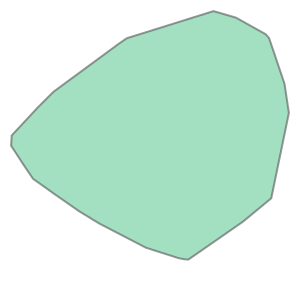

In [12]:
# Choose one Antarctic active subglacial lake polygon with EPSG:3031 coordinates
lake_name: str = "Whillans IX"
lake_catalog = deepicedrain.catalog.subglacial_lakes()
lake_ids, transect_id = (
    pd.json_normalize(lake_catalog.metadata["lakedict"])
    .query("lakename == @lake_name")[["ids", "transect"]]
    .iloc[0]
)
lake = (
    lake_catalog.read()
    .loc[lake_ids]
    .dissolve(by=np.zeros(shape=len(lake_ids), dtype="int64"), as_index=False)
    .squeeze()
)

region = deepicedrain.Region.from_gdf(gdf=lake, name=lake_name)
draining: bool = lake.inner_dhdt < 0

print(lake)
lake.geometry

In [13]:
# Subset data to lake of interest
placename: str = region.name.lower().replace(" ", "_")
df_lake: cudf.DataFrame = region.subset(data=df_dhdt)
# Get all raw xyz points and one transect line dataframe
track_dict: dict = deepicedrain.split_tracks(df=df_lake.to_pandas())
track_points: pd.DataFrame = (
    pd.concat(track_dict.values())
    .groupby(by=["x", "y"])
    .mean()  # z value is mean h_corr over all cycles
    .reset_index()[["x", "y", "h_corr"]]
)
try:
    _rgt, _pt = transect_id.split("_")
    df_transect: pd.DataFrame = (
        track_dict[transect_id][["x", "y", "h_corr", "cycle_number"]]
        .groupby(by=["x", "y"])
        .max()  # z value is maximum h_corr over all cycles
        .reset_index()
    )
except AttributeError:
    pass

# Save lake outline to OGR GMT file format
outline_points: str = f"figures/{placename}/{placename}.gmt"
if not os.path.exists(path=outline_points):
    os.makedirs(name=f"figures/{placename}", exist_ok=True)
    lake_catalog.read().loc[list(lake_ids)].to_file(
        filename=outline_points, driver="OGR_GMT"
    )

100%|██████████| 21/21 [00:00<00:00, 36.83it/s]
